In [1]:
%matplotlib inline
import nengo
import numpy as np

In [62]:
model = nengo.Network()
with model:
    
    def circle(t):
        rate = 0.5
        theta = t * (2 * np.pi) * rate
        return np.sin(theta), np.cos(theta)
    
    stim = nengo.Node(circle)
    
    pre = nengo.Ensemble(n_neurons=300, dimensions=3, radius=1.7)
    
    post = nengo.Ensemble(n_neurons=200, dimensions=2, neuron_type=nengo.LIFRate())
    
    def original_func(x):
        return x[0], x[1]
    
    conn = nengo.Connection(pre, post, function=original_func, learning_rule_type=nengo.PES())
    conn.solver = nengo.solvers.LstsqL2(weights=True)
    
    nengo.Connection(stim, pre[:2])
    
    def error_func(t, x):
        theta = np.arctan2(x[0], x[1])
        theta += x[2]
        return -np.sin(theta) + x[3], -np.cos(theta) + x[4]
    
    error = nengo.Node(error_func, size_in=5, size_out=2)
    nengo.Connection(stim, error[:2])
    nengo.Connection(error, conn.learning_rule)
    nengo.Connection(post, error[3:])
    
    def control_func(t):
        if t % 10 < 5:
            return 0, 0
        else:
            return 1, 0.7
    
    control = nengo.Node(control_func)
    nengo.Connection(control[0], pre[2])
    nengo.Connection(control[1], error[2])
    
    p_post = nengo.Probe(post, synapse=0.01)
    p_error = nengo.Probe(error)
    p_weights = nengo.Probe(conn, 'weights', sample_every=5)

In [63]:
sim = nengo.Simulator(model)
sim.run(200)


Simulation finished in 0:07:39.                                                 


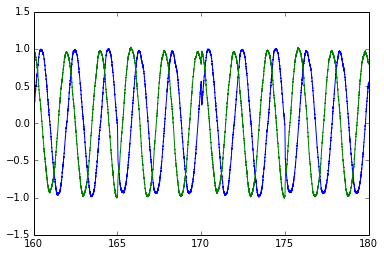

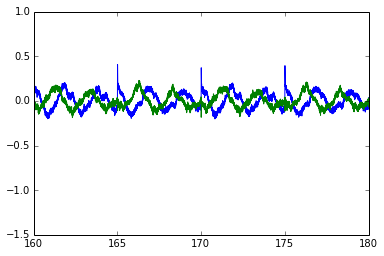

In [64]:
import pylab
pylab.plot(sim.trange(), sim.data[p_post])
pylab.xlim(160, 180)
pylab.figure()
pylab.plot(sim.trange(), sim.data[p_error])
pylab.xlim(160, 180)
pylab.show()


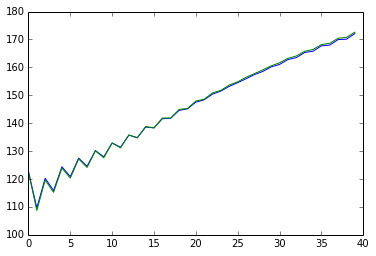

In [65]:
all_pos = []
all_neg = []
for w in sim.data[p_weights]:
    pos = np.sum(np.where(w>0,w,0))
    neg = np.sum(np.where(w<0,-w,0))
    all_pos.append(pos)
    all_neg.append(neg)
    
pylab.plot(all_pos)
pylab.plot(all_neg)
pylab.show()

    
    